In [1]:
import requests
import fecfile
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from dateutil.parser import parse
from IPython.display import display

Time the notebook

In [2]:
start = datetime.datetime.now()

Set some viewing options

In [3]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 500)

Read dataframe of filings

In [4]:
filings = (
    pd.read_csv("../data/filings.csv")
)

filings.head()

,committee_id,candidate_name,filing_id,cycle,form_type,date_filed,date_coverage_to,date_coverage_from,report_title,report_period,fec_uri,paper,amended,amended_uri,is_amendment,original_filing,original_uri,committee_type,contributions_total,cash_on_hand,disbursements_total,receipts_total
0,C00695510,Cory Booker,1341109,2020,F3,2019-07-15,2019-06-30,2019-04-01,JUL QUARTERLY,Q2,http://docquery.fec.gov/cgi-bin/dcdev/forms/C00695510/1341109/,False,False,NaN,NaN,NaN,NaN,P,4542477.41,5360505.51,5317915.17,4547410.25
1,C00695510,Cory Booker,1325860,2020,F1,2019-04-15,NaN,NaN,STATEMENT OF ORGANIZATION,NaN,http://docquery.fec.gov/cgi-bin/dcdev/forms/C00695510/1325860/,False,False,NaN,True,NaN,http://docquery.fec.gov/cgi-bin/dcdev/forms/C00695510//,P,NaN,NaN,NaN,NaN
2,C00695510,Cory Booker,1326465,2020,F3,2019-04-15,2019-03-31,2019-01-01,APR QUARTERLY,Q1,http://docquery.fec.gov/cgi-bin/dcdev/forms/C00695510/1326465/,False,False,NaN,NaN,NaN,NaN,P,5103710.09,6131010.43,1792193.85,7923204.28
3,C00695510,Cory Booker,1313332,2020,F1,2019-02-01,NaN,NaN,STATEMENT OF ORGANIZATION,NaN,http://docquery.fec.gov/cgi-bin/dcdev/forms/C00695510/1313332/,False,False,NaN,True,NaN,http://docquery.fec.gov/cgi-bin/dcdev/forms/C00695510//,P,NaN,NaN,NaN,NaN
4,C00694455,Kamala Harris,1341232,2020,F3,2019-07-15,2019-06-30,2019-04-01,JUL QUARTERLY,Q2,http://docquery.fec.gov/cgi-bin/dcdev/forms/C00694455/1341232/,False,False,NaN,NaN,NaN,NaN,P,11836329.07,13272360.17,7533161.40,11847396.75


In [5]:
filings['candidate_name'].head()

0      Cory Booker
1      Cory Booker
2      Cory Booker
3      Cory Booker
4    Kamala Harris
Name: candidate_name, dtype: object

Get only the quarterlies

In [6]:
quarterlies = (
    filings
    # get quarters
    .loc[
        lambda x: x['report_period'].str.contains("Q", na=False)
    ]
    # remove filings that have been superceded by subsequent filings
    .loc[
        lambda x: x['amended'] == False
    ]
    .sort_values(['candidate_name', 'report_period'])
)

## Parse all the fec files with the filing list

### But first, more convenience functions..

This function, when given a filing ID, returns only the contributions from individual donors:

In [7]:
def extract_contributions(filing_id):
    filing = fecfile.from_file(f"../data/filings/{filing_id}.fec")
    meta = filing['filing']
    
    # get only schedule A
    schedule_a = pd.DataFrame(filing["itemizations"]["Schedule A"])
    
    # remove time zone
    schedule_a["contribution_date"] = schedule_a["contribution_date"].dt.tz_localize(None)
    
    return (
        schedule_a
        
        # Extract only individual contributions
        .loc[lambda df: df["entity_type"] == "IND"]
        
        # Remove memo lines
        .loc[lambda df: df["memo_code"] == ""]
        
        .assign(
            filing_id = int(filing_id),
            
        )
        # filter schedule A
        [[
            "entity_type",
            "filer_committee_id_number",
            "filing_id",
            "transaction_id",
            "contribution_date",
            "contribution_amount",
            "contribution_aggregate",
            "contributor_organization_name",
            "contributor_first_name",
            "contributor_last_name",
            "contributor_zip_code",
            "contributor_state"
        ]]
    )

Create a unique ID out of first name, last name and 5-digit ZIP code

In [8]:
def make_donor_ids(df):
    return (
        df
        .assign(
            donor_id = lambda df: (
                df
                .assign(
                    zip5 = lambda df: (
                        df["contributor_zip_code"]
                        .fillna("-----")
                        .str.slice(0, 5)
                    )
                )
                [[
                    "contributor_first_name",
                    "contributor_last_name",
                    "zip5",
                ]]
                .apply(lambda x: (
                    x
                    .fillna("")
                    .astype(str)
                    # Remove periods, commas, extra whitespace
                    .str.replace(r"[\.,\s]+", " ")
                    .str.strip()
                    # Convert everything to upper-case
                    .str.upper()
                ))
                .apply("|".join, axis = 1)
            )
        )
    )

In [9]:
# takes concatenated contribution dataframe and merges with metadata
def get_metadata(contributions):
    candidate_filings = (
        filings
        [["filing_id",
        "candidate_name",
        "date_filed",
        "date_coverage_to",
        "date_coverage_from",
        "report_title",
        "report_period"]]
    )
    
    return (
        contributions
        .merge(
            candidate_filings,
            on = "filing_id",
            how = "left"
        )
    )

Concatenate all the filings data into one big DataFrame, and get individual contributions only

In [10]:
all_indiv = (
    pd
    .concat(
        [ extract_contributions(e) for  e in quarterlies['filing_id'].tolist() ]
    )
    .pipe( get_metadata )
    .pipe( make_donor_ids )
)

Remove the donors who have given $200 or less, or have been refunded to that level

In [11]:
# First build a frame of latest contributions
latest_contribs = (
    all_indiv
    .sort_values('contribution_date')
    .groupby([ 'candidate_name', 'donor_id'])
    .pipe(lambda grp: pd.DataFrame({
        "latest_contribution_aggregate": grp["contribution_aggregate"].last(),
        })
    )
    .reset_index()
)

latest_contribs.sort_values(
    'latest_contribution_aggregate',
    ascending = False
).head(3)


,candidate_name,donor_id,latest_contribution_aggregate
127069,John Hickenlooper,JOHN|HICKENLOOPER|80202,32800.0
119800,Joe Biden,LARRY|ROCKEFELLER|10154,16800.0
138576,Kamala Harris,KAYE|FOSTER|94403,14000.0


Get list of individual contributions from individuals who have given more than $200, the official itemization threshold

In [12]:
threshold_indiv = (
    all_indiv
    .merge(
        latest_contribs,
        on = ['donor_id', 'candidate_name'],
        how= "left"
    )
    .loc[
        lambda x: x["latest_contribution_aggregate"] > 200
    ]
    .loc[
        lambda x: x["contribution_amount"] > 0
    ]
    .sort_values('latest_contribution_aggregate', ascending = False)

)

## Donation timing

How many donations per day did the candidates get over all months?

In [22]:
# get list of candidates in descending order by distinct donors
candidates = (
    threshold_indiv
    .groupby('candidate_name')
    ['donor_id']
    .nunique()
    .reset_index()
    .sort_values('donor_id', ascending = False)
    ['candidate_name']
    .tolist()
)

candidates

['Bernie Sanders',
 'Pete Buttigieg',
 'Elizabeth Warren',
 'Kamala Harris',
 'Joe Biden',
 'Donald Trump',
 "Beto O'Rourke",
 'Cory Booker',
 'Amy Klobuchar',
 'Jay Inslee',
 'Kirsten Gillibrand',
 'Andrew Yang',
 'John Hickenlooper',
 'Tulsi Gabbard',
 'Marianne Williamson',
 'Julián Castro',
 'Michael Bennet',
 'Steve Bullock',
 'Seth Moulton',
 'John Delaney',
 'Eric Swalwell',
 'Bill de Blasio',
 'Tim Ryan',
 'Wayne Messam',
 'Mike Gravel']

Number of unique donors per day, 1/1/2019 through 6/30/2019


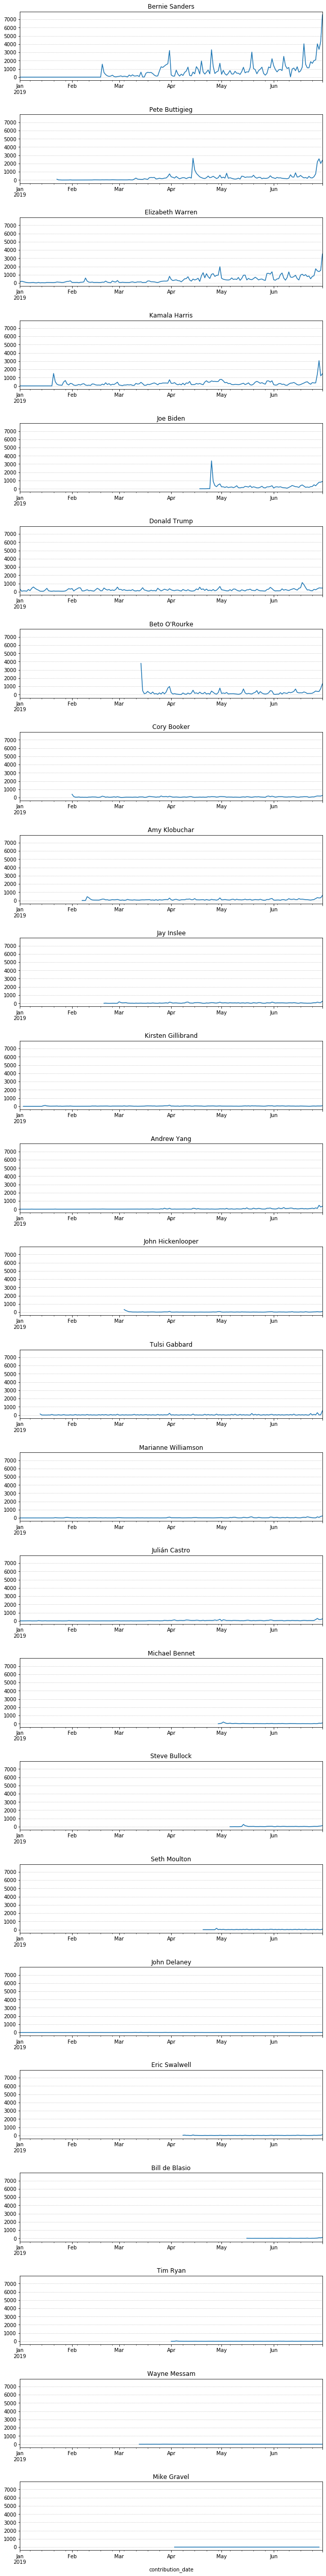

In [20]:
print("Number of unique donors per day, 1/1/2019 through 6/30/2019")

# Set up small multiples
fig, axes = plt.subplots( 
    nrows = len(candidates), 
    ncols = 1, 
    figsize = (9, 2.8 * len(candidates)),     
    sharey = True,
)

plt.tight_layout()

# Make sure there is enough veritcal room between plots
plt.subplots_adjust(hspace = 0.5)

# For each candidate plot their yearly 
for idx, each in enumerate(candidates):
    ax = axes[idx]
    
    ax = (
        threshold_indiv
        .loc[
            lambda x: threshold_indiv['candidate_name'] == each
        ]
        .set_index('contribution_date')
        .groupby(
            pd.Grouper(
                freq = 'D'
            )
        )['donor_id']
        .nunique()
        .plot(
        ax = ax,
        title = each
        )
    )
    
    tick_spacing = 1000

    ax.yaxis.set_major_locator(
        ticker.MultipleLocator(tick_spacing)
    )
    
    ax.yaxis.grid(which = "major", linestyle = ":")
    
    # One year limit
    ax.set_xlim(
        [datetime.datetime(2019,1,1), datetime.datetime(2019,6,30)])
    
    # Remove x labels for all but last plot
    if idx != (len(candidates) - 1):
        ax.set_xlabel("")
        
fig.savefig("../output/donors_per_day.png", dpi = 180)

View just one candidate's daily donation history

In [24]:
def donor_history(candidate_name = "Bernie Sanders"):
    res = (
        threshold_indiv
        .loc[
            lambda x: (x["contribution_date"].dt.year == 2019) & (x["contribution_date"].dt.month < 7 ) 
        ]
        .loc[
            lambda x: threshold_indiv['candidate_name'] == candidate_name
        ]
        .set_index('contribution_date')
        .groupby(
            pd.Grouper(
                freq = 'D'
            )
        )
        ['donor_id']
        .nunique()
        .reset_index()
        .rename(columns = {"donor_id": "donors"})
    )
 
    
    return res

In [25]:
donor_history("Cory Booker")

,contribution_date,donors
0,2019-02-01,395
1,2019-02-02,119
2,2019-02-03,45
3,2019-02-04,45
4,2019-02-05,70
5,2019-02-06,34
6,2019-02-07,39
7,2019-02-08,32
8,2019-02-09,35
9,2019-02-10,25


Build DataFrame of all candidates, all dates

In [31]:
donors_per_day = (
    threshold_indiv
    .loc[
        lambda x: (x["contribution_date"].dt.year == 2019) & (x["contribution_date"].dt.month < 7 ) 
    ]
    .groupby(['contribution_date', 'candidate_name'])
    ['donor_id']
    .nunique()
    .reset_index()
    .pivot(
        index = "contribution_date",
        columns = "candidate_name"
    )
)

# remove the top level of column names
donors_per_day.columns = donors_per_day.columns.droplevel(0)

# reorder columns and write out
donors_per_day[candidates].to_csv("../output/donors_per_day.csv")

In [32]:
end = datetime.datetime.now()

d = (end - start)

f"The notebook ran for {round(d.total_seconds() / 60, 2) } minutes"

'The notebook ran for 81.5 minutes'

---

---

---